In [143]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import json

In [144]:
df = pd.read_csv('train.csv')
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [145]:
numerical_cols = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

In [146]:
features = numerical_cols + [f'Wilderness_Area{i}' for i in range(1,5)] + [f'Soil_Type{i}' for i in range(1,41)]

X = df[features]
y = df['Cover_Type'] - 1

In [147]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])

In [154]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [149]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax')
])

c:\Users\seneh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [150]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [151]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
)

In [152]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5758 - loss: 1.0450 - val_accuracy: 0.6908 - val_loss: 0.7316
Epoch 2/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6888 - loss: 0.7522 - val_accuracy: 0.7202 - val_loss: 0.6604
Epoch 3/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7042 - loss: 0.7011 - val_accuracy: 0.7345 - val_loss: 0.6298
Epoch 4/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7230 - loss: 0.6628 - val_accuracy: 0.7513 - val_loss: 0.5952
Epoch 5/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7321 - loss: 0.6387 - val_accuracy: 0.7626 - val_loss: 0.5798
Epoch 6/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7418 - loss: 0.6165 - val_accuracy: 0.7702 - val_loss: 0.5657
Epoch 7/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7471 - loss: 0.5962 - val_accuracy: 0.7652 - val_loss: 0.5626
Epoch 8/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7515 - loss: 0.5876 - val_accu

In [155]:
model.export('forest_cover_model')

INFO:tensorflow:Assets written to: forest_cover_model\assets


INFO:tensorflow:Assets written to: forest_cover_model\assets


Saved artifact at 'forest_cover_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 54), dtype=tf.float32, name='keras_tensor_53')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2655079082000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2655079080272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2655079086992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2655079085072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2655079082960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2655079080656: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [156]:
history_dict = history.history
with open('history.json', 'w') as f:
    json.dump(history_dict, f)

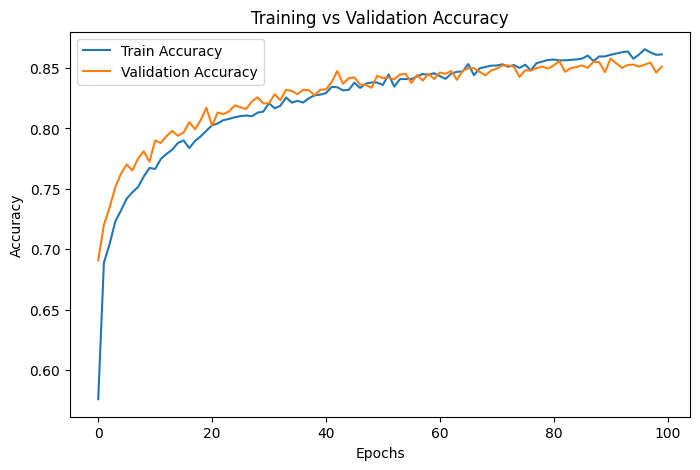

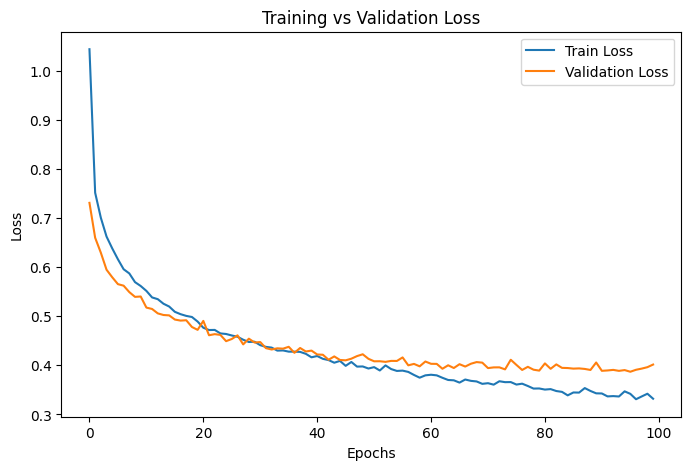

In [153]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()
